In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorboard as tb
import datetime
from tensorflow.keras import layers

2023-06-01 02:38:45.053855: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-01 02:38:45.092497: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-01 02:38:45.093751: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 02:38:45.701154: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
csv_file = 'credit_customers.csv'
dataframe = pd.read_csv(csv_file)

In [3]:
dataframe['class'] = np.where(dataframe['class']=='bad', 0, 1)

In [4]:
dataframe[['sex', 'marriage']] = dataframe.personal_status.str.split(" ", expand = True)
dataframe.drop(['personal_status'], axis=1, inplace = True) # Personal status satırında cinsiyet ve medeni durum birlikte onları ayırıyoruz

In [5]:
input_features = dataframe.copy()
result_labels = input_features.pop('class')

In [39]:
#train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])

In [40]:
#print(len(train), 'training examples')
#print(len(val), 'validation examples')
#print(len(test), 'test examples')

800 training examples
100 validation examples
100 test examples


In [41]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('class')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [42]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

/tmp/ipykernel_68793/4009967357.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [43]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of targets:', label_batch )

Every feature: ['checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_status', 'employment', 'installment_commitment', 'other_parties', 'residence_since', 'property_magnitude', 'age', 'other_payment_plans', 'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker', 'class', 'sex', 'marriage']
A batch of targets: tf.Tensor([0 0 0 1 0], shape=(5,), dtype=int64)


2023-05-31 23:59:09.882297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_18' with dtype string and shape [800,1]
	 [[{{node Placeholder/_18}}]]
2023-05-31 23:59:09.882986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [800,1]
	 [[{{node Placeholder/_4}}]]


In [44]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [45]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [46]:
categoricals=[]
numericals=[]
for l,k in dataframe.items():
    if k.dtype=='O':
        categoricals.append(l)
    else:
        numericals.append(l)
print(categoricals)
print(numericals)  

['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker', 'sex', 'marriage']
['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents', 'class']


In [47]:
numericals.remove('class')
numericals

['duration',
 'credit_amount',
 'installment_commitment',
 'residence_since',
 'age',
 'existing_credits',
 'num_dependents']

In [58]:
batch_size = 1
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

/tmp/ipykernel_68793/4009967357.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_68793/4009967357.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_68793/4009967357.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [59]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in numericals:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

2023-06-01 00:07:38.481289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [800,1]
	 [[{{node Placeholder/_4}}]]
2023-06-01 00:07:38.483004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_21' with dtype string and shape [800,1]
	 [[{{node Placeholder/_21}}]]
2023-06-01 00:07:39.041502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype string and shape [

In [60]:
for header in categoricals:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

2023-06-01 00:07:42.309068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype string and shape [800,1]
	 [[{{node Placeholder/_6}}]]
2023-06-01 00:07:42.309628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [800,1]
	 [[{{node Placeholder/_7}}]]
2023-06-01 00:07:42.675622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [800

2023-06-01 00:07:47.363950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype string and shape [800,1]
	 [[{{node Placeholder/_12}}]]
2023-06-01 00:07:47.364498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_22' with dtype int64 and shape [800]
	 [[{{node Placeholder/_22}}]]
2023-06-01 00:07:47.763406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype string and shape [8

In [61]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [62]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [63]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)

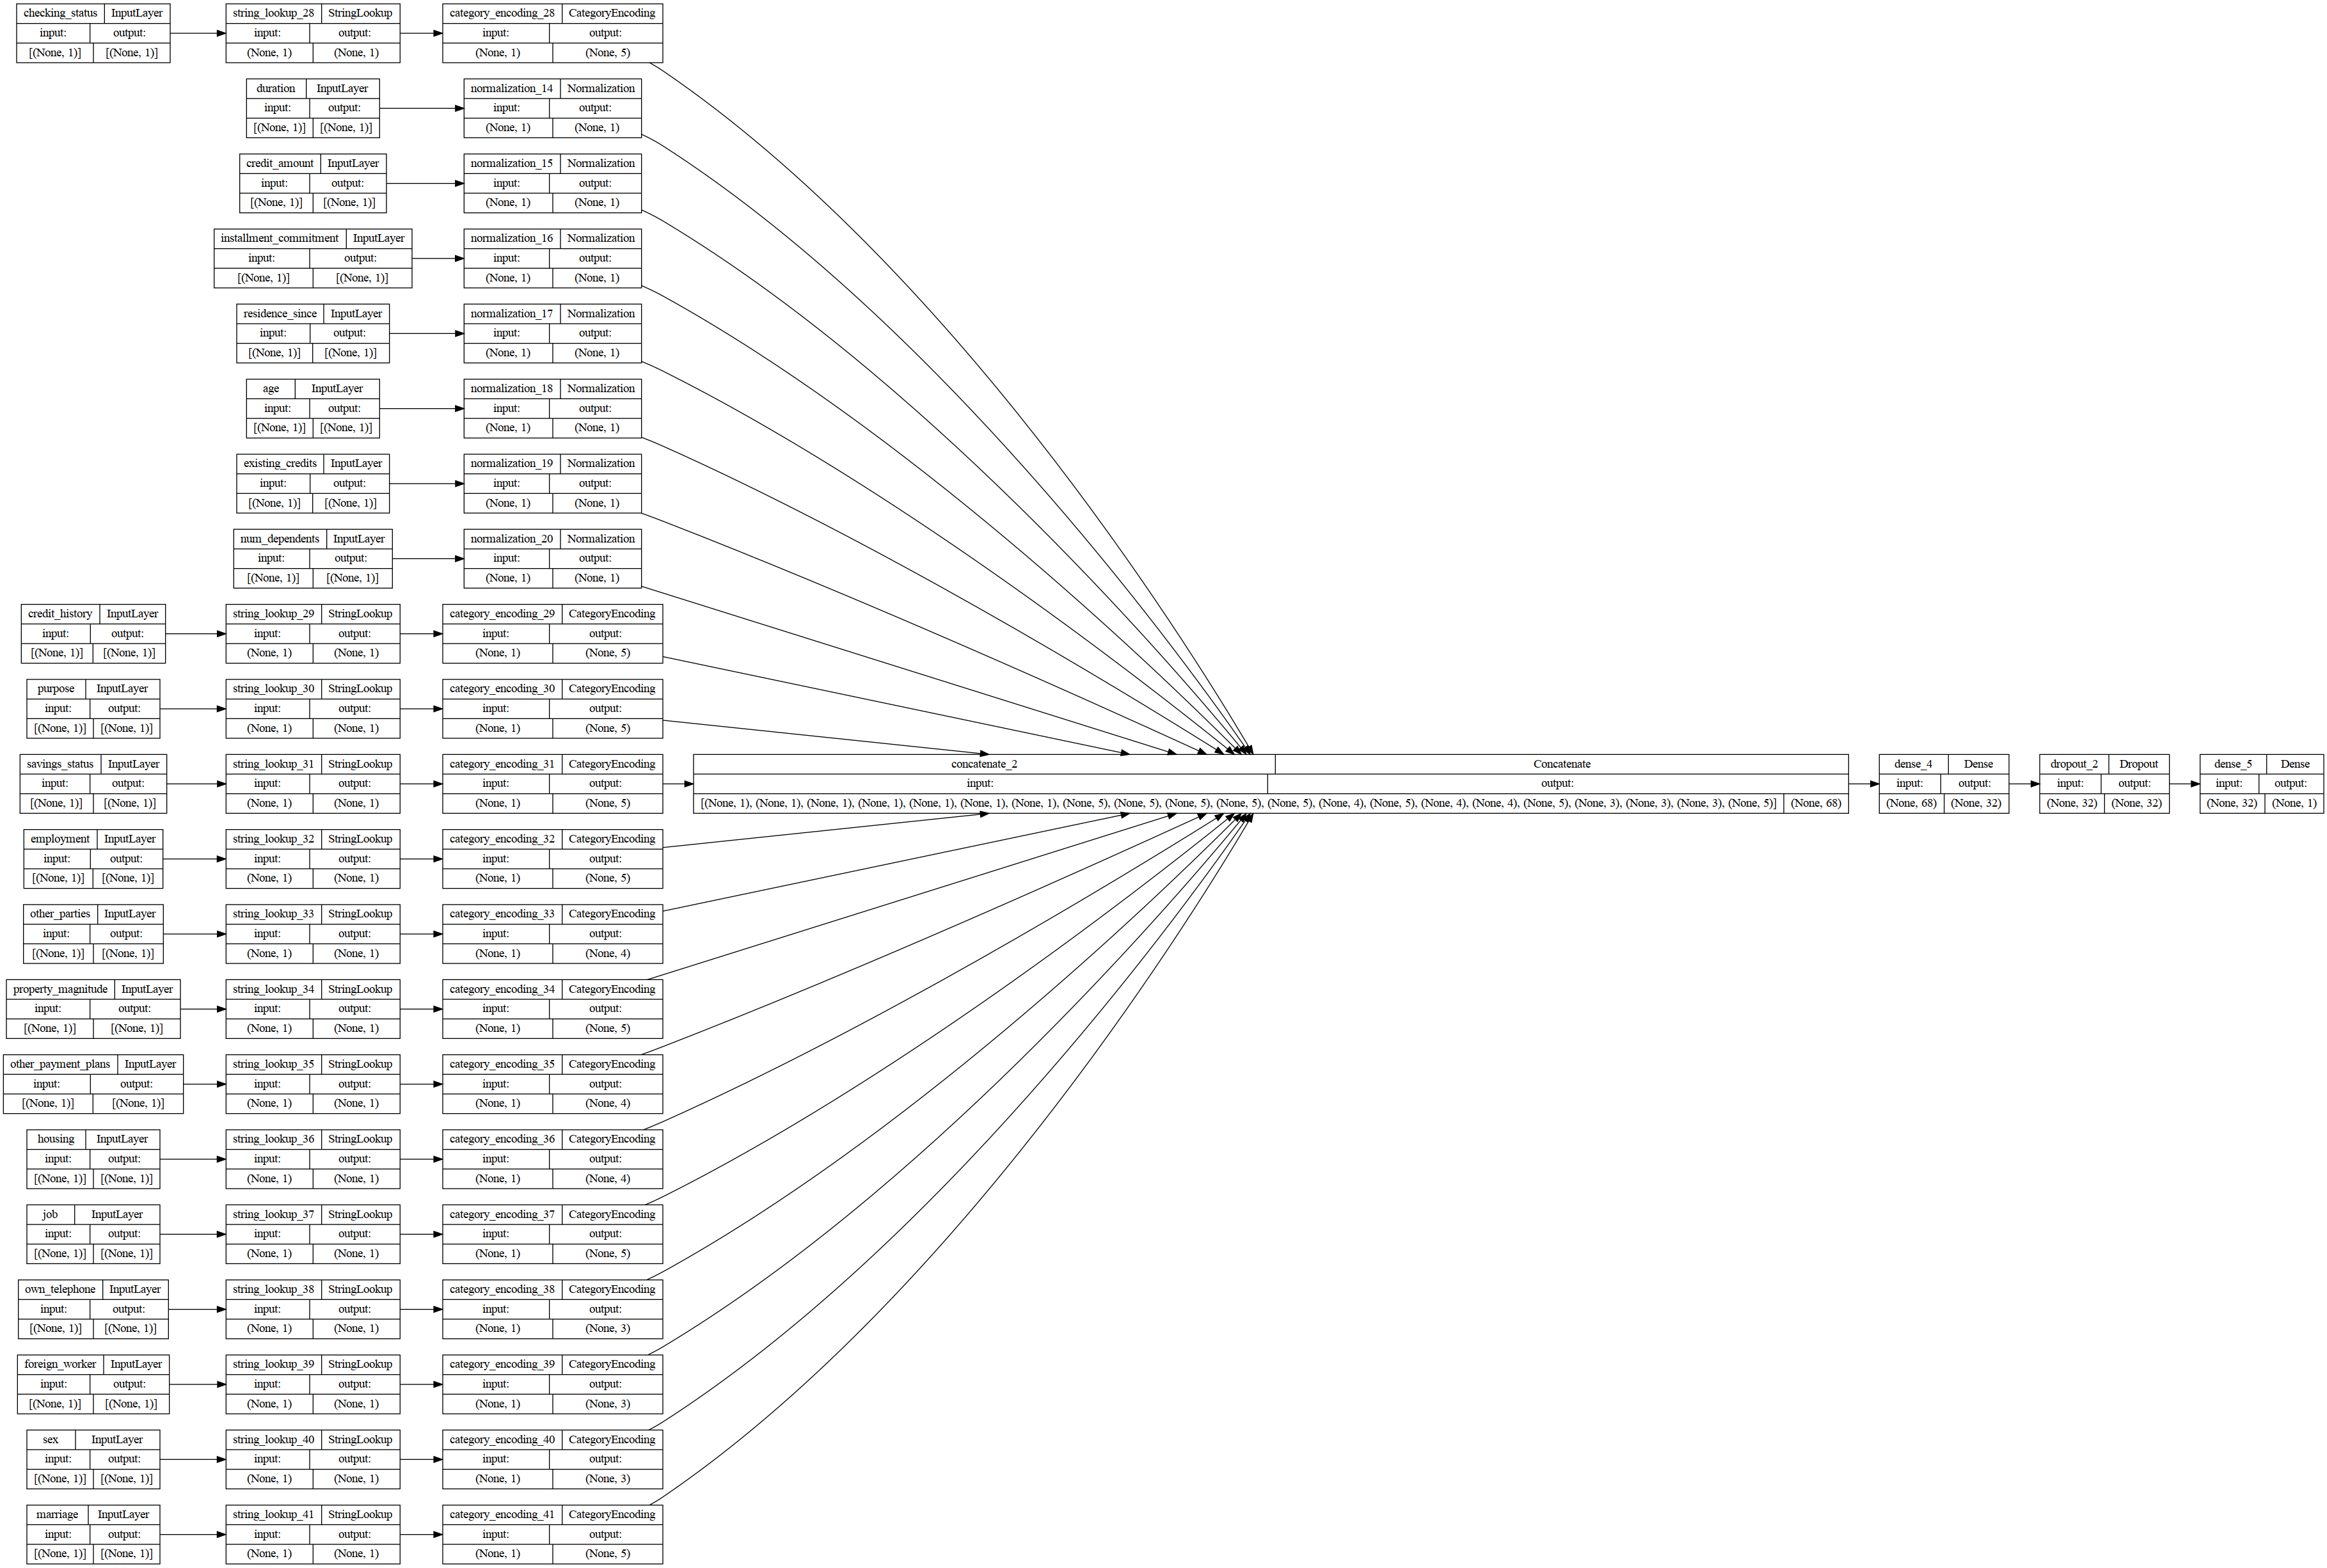

In [64]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [65]:
model.fit(train_ds, epochs=100, validation_data=val_ds,callbacks=[tensorboard_callback]) 

Epoch 1/100


2023-06-01 00:07:48.681241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype string and shape [800,1]
	 [[{{node Placeholder/_8}}]]
2023-06-01 00:07:48.682634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [800,1]
	 [[{{node Placeholder/_4}}]]
/home/usern/projects/DL/.venv/lib/python3.11/site-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['class'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


793/800 [============================>.] - ETA: 0s - loss: 0.6199 - accuracy: 0.6166

2023-06-01 00:07:51.335517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [100,1]
	 [[{{node Placeholder/_7}}]]
2023-06-01 00:07:51.336028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype double and shape [100,1]
	 [[{{node Placeholder/_5}}]]


800/800 [==============================] - 3s 3ms/step - loss: 0.6207 - accuracy: 0.6162 - val_loss: 0.6288 - val_accuracy: 0.6400
Epoch 2/100
800/800 [==============================] - 2s 2ms/step - loss: 0.5283 - accuracy: 0.6988 - val_loss: 0.6090 - val_accuracy: 0.6700
Epoch 3/100
800/800 [==============================] - 2s 2ms/step - loss: 0.4856 - accuracy: 0.7287 - val_loss: 0.6129 - val_accuracy: 0.6600
Epoch 4/100
800/800 [==============================] - 2s 2ms/step - loss: 0.4844 - accuracy: 0.7588 - val_loss: 0.6136 - val_accuracy: 0.6900
Epoch 5/100
800/800 [==============================] - 2s 2ms/step - loss: 0.4687 - accuracy: 0.7688 - val_loss: 0.6166 - val_accuracy: 0.6900
Epoch 6/100
800/800 [==============================] - 2s 2ms/step - loss: 0.4609 - accuracy: 0.7513 - val_loss: 0.5973 - val_accuracy: 0.6700
Epoch 7/100
800/800 [==============================] - 2s 2ms/step - loss: 0.4513 - accuracy: 0.7700 - val_loss: 0.6435 - val_accuracy: 0.6900
Epoch 8/100

KeyboardInterrupt: 

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

In [57]:
#model.save('exportedModelacc82')
#reloaded_model = tf.keras.models.load_model('my_pet_classifier')